In [1]:
import torch
import torchvision
from torchvision import transforms

import pytorch_lightning as pl

from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.loggers import CSVLogger

from pytorch_lightning.callbacks import ModelCheckpoint,LearningRateMonitor,ModelSummary
from pytorch_lightning.callbacks.progress import TQDMProgressBar


from torch.nn import functional as F
from torch.utils.data import DataLoader

#Metricas
import torchmetrics
from torchmetrics.classification import MulticlassAccuracy


from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from torch.utils.tensorboard import SummaryWriter



In [2]:
##########################
### Configurações
##########################

### MODEL_NAME = MODELO + IMAGENS + DETALHES
#MODEL_NAME = "CNN_TCC_IMG224_ALL_B_NORMALIZE_ROTATION45"

# Hyperparameters
#RANDOM_SEED = 1
#LEARNING_RATE = 1e-4
LEARNING_RATE = 0.001
BATCH_SIZE = 8 if torch.cuda.is_available() else 64
NUM_WORKERS = 0 # Zero for Windows
#NUM_EPOCHS = 30

# Architecture
NUM_CLASSES = 7

# Other
DEVICE = "cuda:0" # ou "CPU"

width_pic = 224
height_pic = 224


In [3]:
# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('./lightning_logs')


In [6]:
PATH_DS_PROCESSED_TEST = Path("./IMG224_ALL/PROCESSED-TEST")


In [7]:
def load_file(path):
    return np.load(path).astype(np.float32)

In [30]:
mean = torch.tensor([118.9568,  76.7986,  43.6991]) 
stq = torch.tensor([71.9256, 50.9931, 35.3619])    

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean,stq),
])

test_transforms_nao_norm = transforms.Compose([
    transforms.ToTensor(),
])


In [31]:
#Datasets
TEST_DATASET = torchvision.datasets.DatasetFolder(
    PATH_DS_PROCESSED_TEST,
    loader=load_file, extensions="npy", transform=test_transforms)


TEST_DATASET_NAO_NORMALIZADA = torchvision.datasets.DatasetFolder(
    PATH_DS_PROCESSED_TEST,
    loader=load_file, extensions="npy", transform=test_transforms_nao_norm)


In [11]:
TEST_LOADER = torch.utils.data.DataLoader(TEST_DATASET, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=False)

In [9]:
class CNN_TCC(torch.nn.Module):
    def __init__(self, numChannels, classes):
        
        super().__init__()
        self.model = torch.nn.Sequential(
            torch.nn.Conv2d(numChannels,10,(3,3)),
            torch.nn.ReLU(),
            torch.nn.Conv2d(10,15,(3,3)),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=(3, 3), stride=(2, 2)), # imagem tem 220x220 / 2 = 110x110
            torch.nn.Flatten(),
            torch.nn.Linear(15*(109*109) , classes)
        )
    
    def forward(self, x):
        return self.model(x)


In [10]:
class CNN_TCC(torch.nn.Module):
    def __init__(self, numChannels, classes):
        
        super().__init__()
        # Camada convolucional com saida de 10 camadas de mapas
        self.conv1 = torch.nn.Conv2d(in_channels=numChannels, out_channels=15, kernel_size=(3, 3))
        # Camada de ReLU para remover os valores negativos
        self.relu1 = torch.nn.ReLU()
        # Camada de compactação ("Pooling") para reduzir as dimenções das camadas geradas pela Convolução
        self.pooling = torch.nn.MaxPool2d(kernel_size=(3, 3), stride=(2, 2))
        # Uma camada 100% conectada responsavel para classificação
        self.full_connect = torch.nn.Linear(in_features=15*(110*110), out_features=classes)
      
        self.logSoftmax = torch.nn.LogSoftmax(dim=1)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pooling(x)
        x = torch.flatten(x, 1)
        x = self.full_connect(x)
        
        output = self.logSoftmax(x)

        return output

In [12]:
class CNN_SIMPLES(torch.nn.Module):
    def __init__(self, numChannels, classes):
        
        super().__init__()
        # Camada convolucional com saida de 15 camadas de mapas de recursos
        self.conv1 = torch.nn.Conv2d(in_channels=numChannels, out_channels=15, kernel_size=(3, 3))
        # Camada de ReLU para remover os valores negativos
        self.relu1 = torch.nn.ReLU()
        # Camada de compactação ("Pooling") para reduzir as dimenções das camadas geradas pela Convolução
        self.pooling = torch.nn.MaxPool2d(kernel_size=(3, 3), stride=(3, 3))
        # Uma camada 100% conectada responsavel pela classificação
        self.full_connect1 = torch.nn.Linear(in_features=15*(74*74), out_features=100)
        self.full_connect2 = torch.nn.Linear(100, out_features=classes)
        #Função LogSoftmax para trabalhar com a função de perda CrossEntropyLoss
        self.logSoftmax = torch.nn.LogSoftmax(dim=1)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pooling(x)
        x = torch.flatten(x, 1)
        x = self.full_connect1(x)
        x = self.full_connect2(x)
        
        output = self.logSoftmax(x)
        return output

In [13]:
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [15]:
dataiter = iter(TEST_LOADER)
images, labels = next(dataiter)

net = CNN_SIMPLES(3,NUM_CLASSES)
writer.add_graph(net, images)
#writer.close()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


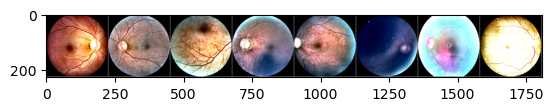

In [16]:
# create grid of images
img_grid = torchvision.utils.make_grid(images)

# show images
matplotlib_imshow(img_grid, one_channel=False)

In [17]:
class LTCNNSimplestModule(pl.LightningModule):
    def __init__(self):

        super().__init__()
        
        self.learning_rate = LEARNING_RATE      

        self.model = CNN_SIMPLES(3,NUM_CLASSES)
        self.model.cuda(0)

        self.loss_fn = torch.nn.CrossEntropyLoss()
        
        self.metric_train_accuracy = torchmetrics.classification.MulticlassAccuracy(num_classes=NUM_CLASSES)
        self.metric_val_accuracy = torchmetrics.classification.MulticlassAccuracy(num_classes=NUM_CLASSES)
        self.metric_test_accuracy = torchmetrics.classification.MulticlassAccuracy(num_classes=NUM_CLASSES)
    
    def forward(self, x):
        x = self.model(x)
        return x
    
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.learning_rate)
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[4,8,10,15,20], gamma=0.7)
        
        return [optimizer], [scheduler]
        
    def training_step(self, batch, batch_idx):
        x, labels = batch
        preds = self.model(x)
        loss = self.loss_fn(preds, labels)

        self.metric_train_accuracy.update(preds.argmax(dim=-1), labels.int())
        
        self.log("train_st_loss", loss, prog_bar=True)

        
        return loss
    
    def training_epoch_end(self, outs):
        self.log("train_ep_acc", self.metric_train_accuracy.compute())
        self.metric_train_accuracy.reset()

    def validation_step(self, batch, batch_idx):
        x, labels = batch
        preds = self.model(x).argmax(dim=-1)
        self.log("val_step_acc", self.metric_val_accuracy(preds, labels))
        
    def validation_epoch_end(self, outs):
        self.log("val_epoch_acc", self.metric_val_accuracy.compute(), prog_bar=True)
        self.metric_val_accuracy.reset()

    def test_step(self, batch, batch_idx):
        x, labels = batch
        preds = self.model(x).argmax(dim=-1)
        acc = (labels == preds).float().mean()
        self.log("test_acc", acc)


In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


model = LTCNNSimplestModule.load_from_checkpoint("./WEIGHTS/CNN_TCC/epoch=27-step=17864.ckpt")
model.eval()
model.to(device);


In [22]:
eval_dataset = TEST_DATASET

In [23]:

preds = []
labels = []
names = []
i = 0

with torch.no_grad():
    for data, label in tqdm(eval_dataset):
        data = data.to(device).float().unsqueeze(0)
        pred = torch.sigmoid(model(data)[0].cpu())
        pred2 = pred.argmax(dim=-1)
        preds.append(pred2)
        labels.append(label)
        names.append(eval_dataset.samples[i][0].split("\\")[2])
        
        i+=1

preds = torch.tensor(preds)
labels = torch.tensor(labels).int()


  0%|          | 0/1386 [00:00<?, ?it/s]

In [24]:
#        0-N - Normal
#        1-D - Diabetes
#        2-G - Glaucoma
#        3-C - Catarata
#        4-A - Degeneração macular
#        5-H - Hipertensao
#        6-M - Miopia patológica  


acc = torchmetrics.Accuracy(task='multiclass', num_classes=NUM_CLASSES)(preds, labels)
precision = torchmetrics.Precision(task='multiclass', num_classes=NUM_CLASSES)(preds, labels)
recall = torchmetrics.Recall(task='multiclass', num_classes=NUM_CLASSES)(preds, labels)
F1Score = torchmetrics.F1Score(task='multiclass', num_classes=NUM_CLASSES)(preds, labels)

cm = torchmetrics.ConfusionMatrix(task='multiclass',num_classes=NUM_CLASSES)(preds, labels)
#cm_threshed = torchmetrics.ConfusionMatrix(task='multiclass',num_classes=NUM_CLASSES, threshold=0.25)(preds, labels)

print(f"Val Accuracy: {acc}")
print(f"Val Precision: {precision}")
print(f"Val Recall: {recall}")
print(f"Val F1Score: {F1Score }")
print(f"Confusion Matrix:\n {cm}")
#print(f"Confusion Matrix 2:\n {cm_threshed}")

Val Accuracy: 0.6010100841522217
Val Precision: 0.6010100841522217
Val Recall: 0.6010100841522217
Val F1Score: 0.6010100841522217
Confusion Matrix:
 tensor([[702,  50,  17,  26,   2,   6,  16],
        [231,  31,   2,   4,   0,   4,   4],
        [ 52,   2,   7,   0,   1,   0,   3],
        [ 20,   0,   0,  60,   0,   0,   1],
        [ 56,   5,   0,   4,   0,   2,   3],
        [ 24,   2,   0,   0,   0,   1,   0],
        [ 11,   1,   1,   2,   1,   0,  32]])


In [25]:
acc = torchmetrics.Accuracy(task='multiclass', num_classes=NUM_CLASSES, average=None)(preds, labels)
precision = torchmetrics.Precision(task='multiclass', num_classes=NUM_CLASSES, average=None)(preds, labels)
recall = torchmetrics.Recall(task='multiclass', num_classes=NUM_CLASSES, average=None)(preds, labels)
F1Score = torchmetrics.F1Score(task='multiclass', num_classes=NUM_CLASSES, average=None)(preds, labels)



print(f"Val Accuracy: {acc}")
print(f"Val Precision: {precision}")
print(f"Val Recall: {recall}")
print(f"Val F1Score: {F1Score }")

Val Accuracy: tensor([0.8571, 0.1123, 0.1077, 0.7407, 0.0000, 0.0370, 0.6667])
Val Precision: tensor([0.6405, 0.3407, 0.2593, 0.6250, 0.0000, 0.0769, 0.5424])
Val Recall: tensor([0.8571, 0.1123, 0.1077, 0.7407, 0.0000, 0.0370, 0.6667])
Val F1Score: tensor([0.7332, 0.1689, 0.1522, 0.6780, 0.0000, 0.0500, 0.5981])


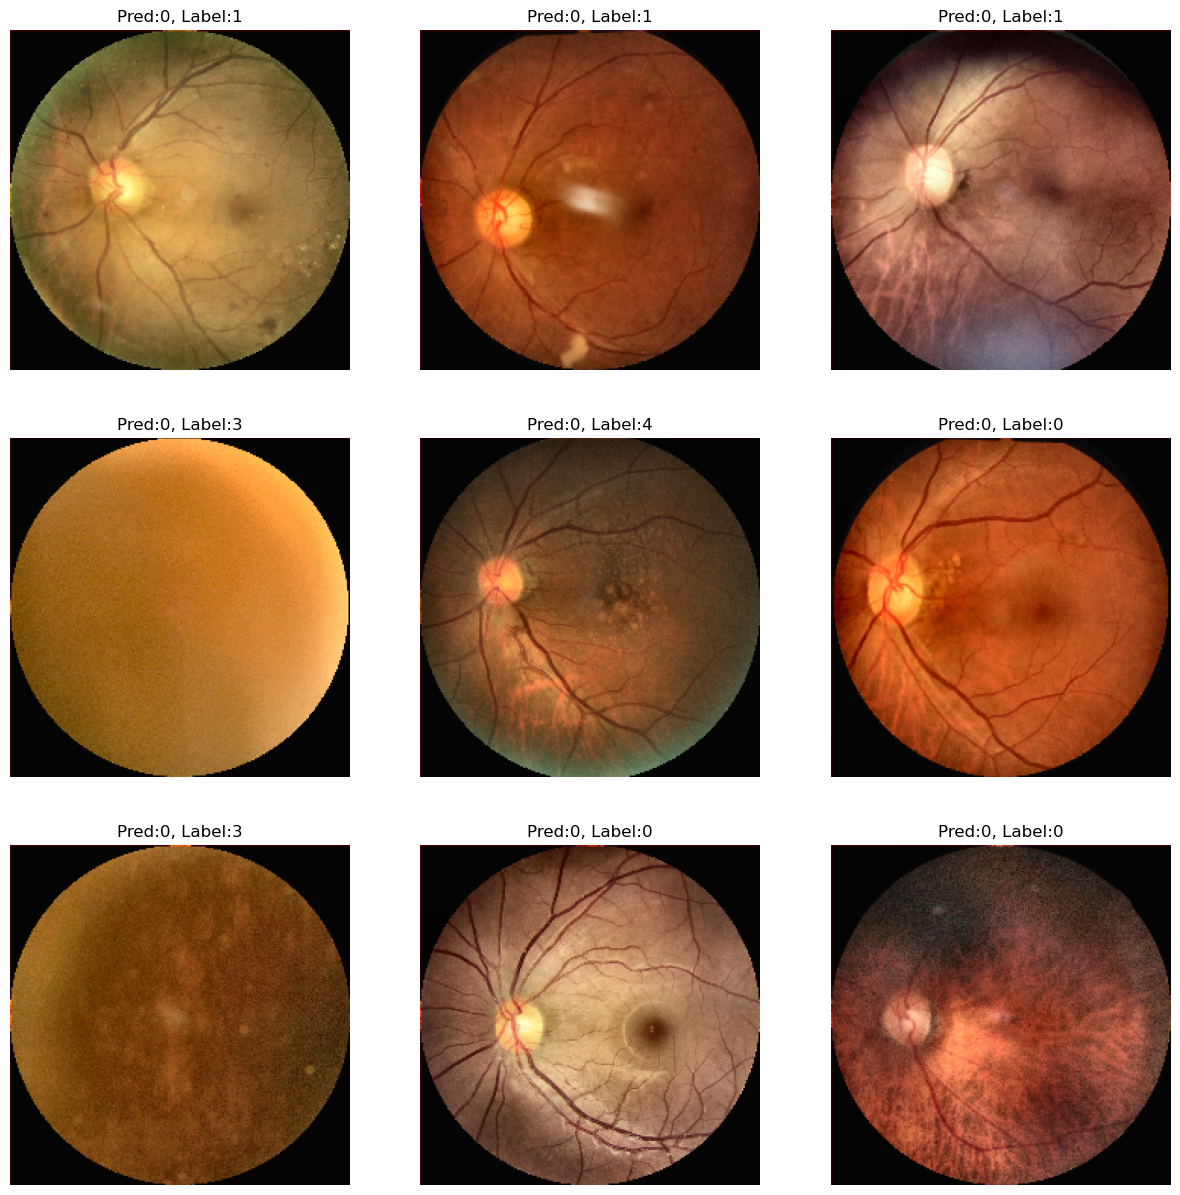

In [32]:
fig, axis = plt.subplots(3, 3, figsize=(15, 15))

for i in range(3):
    for j in range(3):
        rnd_idx = np.random.randint(0, len(preds))
        axis[i][j].imshow(TEST_DATASET_NAO_NORMALIZADA[rnd_idx][0].permute(1, 2, 0).to(torch.int16), cmap="bone")
    
        axis[i][j].set_title(f"Pred:{int(preds[rnd_idx].argmax())}, Label:{labels[rnd_idx]}")
        axis[i][j].axis("off")
